# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

- Keras document : https://keras.io/examples/vision/oxford_pets_image_segmentation/


- Unet paper : https://arxiv.org/abs/1505.04597
- Unet code : https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
- Unet explanation : https://towardsdatascience.com/u-net-b229b32b4a71


- Xception paper : https://arxiv.org/abs/1610.02357
- 'SeparableConv2d' torch code referecne : https://ysbsb.github.io/cnn/2020/02/20/Xception.html

- keras2torch reference : https://github.com/hwk0702/keras2torch/blob/main/Computer_Vision/Image_Segmentation_Unet_Xception/%5BKJS%5DImage%20segmentation%20with%20a%20U-Net-like%20architecture(torch).ipynb

# Setup 

In [20]:
import os 
from glob import glob 

input_dir = './data/Segmentation/images/'
target_dir = './data/Segmentation/annotations/trimaps/'
img_size = (160,160)
num_classes = 3 
batch_size = 32 
device = 'cuda:0'

input_img_paths = sorted(glob(input_dir + '*.jpg'))
target_img_paths = sorted(glob(target_dir + '*.png'))

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
./data/Segmentation/images/Abyssinian_1.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_1.png
./data/Segmentation/images/Abyssinian_10.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_10.png
./data/Segmentation/images/Abyssinian_100.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_100.png
./data/Segmentation/images/Abyssinian_101.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_101.png
./data/Segmentation/images/Abyssinian_102.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_102.png
./data/Segmentation/images/Abyssinian_103.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_103.png
./data/Segmentation/images/Abyssinian_104.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_104.png
./data/Segmentation/images/Abyssinian_105.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_105.png
./data/Segmentation/images/Abyssinian_106.jpg | ./data/Segmentation/annotations/trimaps/Abyssinian_106.png
./data/Segmentation

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
from torchvision.io import read_image

## Image check 

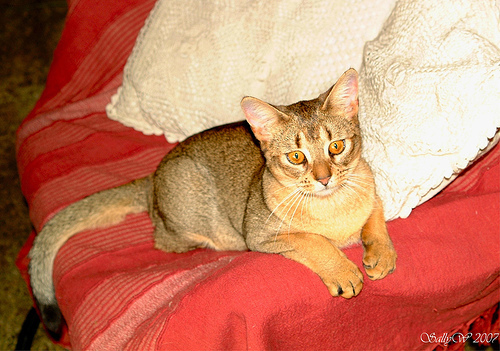

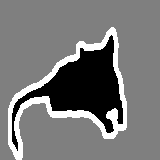

In [21]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[5]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[5],target_size = img_size))
display(img)

## Train - Validation Split 

In [22]:
np.random.seed(42)
np.random.shuffle(input_img_paths)
np.random.shuffle(target_img_paths)

val_samples = 1000 
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
valid_input_img_paths = input_img_paths[-val_samples:]
valid_target_img_paths = target_img_paths[-val_samples:]
print(f"Nums of train images : {len(train_input_img_paths)}")
print(f"Nums of val images : {len(valid_target_img_paths)}")

Nums of train images : 6390
Nums of val images : 1000


## Custom dataset dataloader 

In [23]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, img_size, input_img_paths, target_img_paths):
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths)

    def image(self,path,xy):
        if xy == 'x':
            img = load_img(path,target_size=self.img_size)
            img = np.asarray(img)
            img = np.swapaxes(img,0,2)
        elif xy == 'y':
            img = load_img(path,target_size=self.img_size,color_mode='grayscale')
            img = np.asarray(img)
            img = np.expand_dims(img,axis=0)
        return torch.from_numpy(img)

    def __getitem__(self,idx):
        input_img_path = self.input_img_paths[idx]
        target_img_path = self.target_img_paths[idx]
        input_img = self.image(input_img_path,'x')
        target_img = self.image(target_img_path,'y')

        return input_img, target_img

In [24]:
# Instantiate data Sequences for each split
train_gen = OxfordPets(
    img_size, 
    train_input_img_paths, 
    train_target_img_paths,
)

val_gen = OxfordPets(
    img_size,
    valid_input_img_paths, 
    valid_target_img_paths,
)

train_dataloader = DataLoader(train_gen, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_gen, batch_size=batch_size, shuffle=True)

# Model 

### U-Net Xception-style

- **Down | Up sampling + Depthwise Separable Convolution 사용**

    - U-Net
        - Encoder(Down sampling, conv), Decoder(Up sampling, Transconv)

    - Xception
        - Depthwise Separable Convolution 사용
        
        <img src = "depthwise_conv.png" width="80%" height="80%">
        


**보충**

- Depthwise convolution(SeparableConv2D)
    - **Depthwise conv**(각 채널 별 독립적인 pattern) + **Pointwise conv**(채널 간 pattern)
        - ref : https://www.python2.net/questions-972522.htm
        - ref : https://zzsza.github.io/data/2018/02/23/introduction-convolution/
        - ref : https://www.youtube.com/watch?v=V0dLhyg5_Dw
        - ref : https://hichoe95.tistory.com/48
        
- transposedConv2d vs deconvolution
    - Transposed Conv 2D : 원본의 size 복원
    - Deconv 2D : 원본의 input 복원
    - ref : https://velog.io/@hayaseleu/Transposed-Convolutional-Layer은-무엇인가
    


- Loss.backward() 할 때 inplace modification Error 
    - debugging ref : https://daeheepark.tistory.com/24

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F        


class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

    
class Down_DoubleConv(nn.Module):
    """(ReLU => [BN] => convolution) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_double_conv = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SeparableConv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        return self.down_double_conv(x)
    

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Down_DoubleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up_DoubleConv(nn.Module):
    """(ReLU => [BN] => convolution) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_double_conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        return self.up_double_conv(x)
    
    
class Up(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample_conv = nn.Sequential(
            Up_DoubleConv(in_channels, out_channels),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        return self.upsample_conv(x)
    
    
class Entry(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_c = in_channels
        self.out_c = out_channels
        self.entry = nn.Sequential(
            nn.Conv2d(in_channels=self.in_c, out_channels=self.out_c,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.out_c),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.entry(x)
    
    
class Outro(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_c = in_channels
        self.out_c = out_channels
        self.outro = nn.Conv2d(self.in_c, self.out_c,
                               kernel_size=3, padding=1)
        
    def forward(self, x):
        return self.outro(x)
    

In [9]:
class UNet_Xception(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.entry = Entry(3, 32)
        
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        
        self.up1 = Up(256, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        
        self.outro = Outro(in_channels=32, out_channels=num_classes)
        
        
    def forward(self, x):
        
        # Entry block
        x = self.entry(x)
        x = x.clone()
        
        # Down
        layers = [self.down1, self.down2, self.down3]
        out_cs = [64, 128, 256]
        for idx, (layer, out_c) in enumerate(zip(layers, out_cs)):
            
            previous_block_activation = x

            x = layer(x)

            # Project residual
            residual = nn.Conv2d(in_channels=int(out_c/2), out_channels=out_c,
                                 kernel_size=1, stride=2, padding=0).to(device)(previous_block_activation)
            # Add back residual
            x += residual
            

        # Up
        layers = [self.up1, self.up2, self.up3, self.up4]
        out_cs = [256, 128, 64, 32]
        for idx, (layer, out_c) in enumerate(zip(layers, out_cs)):
        
            previous_block_activation = x
            
            x = layer(x)

            # Project residual
            if idx == 0:
                residual = nn.Upsample(scale_factor=2)(previous_block_activation)
                residual = nn.Conv2d(in_channels=out_c, out_channels=out_c, 
                                     kernel_size=1, stride=1, padding=0).to(device)(residual)
            else:
                residual = nn.Upsample(scale_factor=2)(previous_block_activation)
                residual = nn.Conv2d(in_channels=int(out_c*2), out_channels=out_c, 
                                     kernel_size=1, stride=1, padding=0).to(device)(residual)  
            # Add back residual            
            x += residual

        x = self.outro(x)
        
        return x
        

# Train 

In [16]:
def train_val_net(net, device, num_epochs, train_dataloader, val_dataloader):
    
    optimizer = optim.RMSprop(net.parameters())
    criterion = nn.CrossEntropyLoss()
    net.to(device)
    
    epoch_loss_list_train = []
    epoch_loss_list_val = []

    for epoch in range(num_epochs):

        net.train()
        epoch_loss_train = 0


        for x, y in train_dataloader:

            x, y = x.to(device, dtype=torch.float32), y.squeeze().to(device, dtype=torch.long)

            optimizer.zero_grad()

            pred = net(x)
            
            loss = criterion(pred, y)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += float(loss)

        epoch_loss_list_train.append(float(epoch_loss_train)/len(train_dataloader))

        
        
        net.eval()
        epoch_loss_val = 0
        
        with torch.no_grad():
            for idx, (x, y) in enumerate(val_dataloader):

                x, y = x.to(device, dtype=torch.float32), y.squeeze().to(device, dtype=torch.long)

                val_pred = net(x).to(device)

                loss_val = criterion(val_pred, y)

                epoch_loss_val += float(loss_val)
                
                if idx==0:
                    val_preds = val_pred
                else:
                    val_preds = torch.cat([val_preds, val_pred], axis=0)

            epoch_loss_list_val.append(float(epoch_loss_val)/len(val_dataloader))
        
        print(f"[EPOCH : {epoch}] | train loss : {float(epoch_loss_train)/len(train_dataloader):.4f}, val loss : {float(epoch_loss_val)/len(val_dataloader):.4f}")            
    
    return net, epoch_loss_list_train, epoch_loss_list_val, val_preds

In [25]:
unet_x = UNet_Xception(n_channels=3, n_classes=num_classes)

trained_model, train_losses, val_losses, val_preds = train_val_net(unet_x, 
                                                                   device=device, 
                                                                   num_epochs=30,
                                                                   train_dataloader=train_dataloader,
                                                                   val_dataloader=val_dataloader)

../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [14,0,0], thread: [992,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [14,0,0], thread: [931,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [14,0,0], thread: [932,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [14,0,0], thread: [933,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [14,0,0], thread: [934,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [14,0,0], thread: [935,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/NLLLoss2d.cu:103: nll_loss2d_forward_kernel: block: [

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [15]:
unet_x = UNet_Xception(n_channels=3, n_classes=num_classes)
unet_x.to('cuda')
optimizer = optim.Adam(unet_x.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(50):

    unet_x.train()
    epoch_loss_train = 0 

    

UNet_Xception(
  (entry): Entry(
    (entry): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): Down_DoubleConv(
        (down_double_conv): Sequential(
          (0): ReLU(inplace=True)
          (1): SeparableConv2d(
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU(inplace=True)
          (4): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1